# perform inference using oscillations of random amplitude and frequency


In [2]:
import numpy as np
import os, sys
import json

project_root = os.path.abspath("")  # alternative
if project_root[-12:] == 'LyoSavin2023':
    base_dir = project_root
else:
    base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import torch
import torch.optim as optim
import time
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import zarr
from tqdm.auto import tqdm, trange

from utils import remove_all_ticks_and_labels

## first vary the frequency of the oscillation

we want to maintain the sinusoidal shape, only varying the frequency

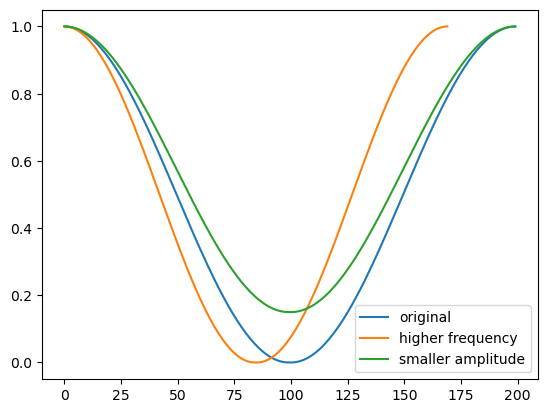

In [3]:
# show the different beta schedules
from utils import make_beta_schedule, convert_beta_l_to_beta_t, convert_beta_t_to_beta_l

n_timesteps = 100

betas = make_beta_schedule('sine', n_timesteps=n_timesteps)

def make_beta_t_schedule(n_timesteps=100, n_periods=1):
    betas = make_beta_schedule(schedule='sine', n_timesteps=n_timesteps)
    betas_one_period = torch.cat([betas, reversed(betas)])
    beta_t_one_period = convert_beta_l_to_beta_t(betas_one_period, betas)
    beta_t = torch.cat([beta_t_one_period for _ in range(n_periods)])
    return beta_t

# original beta schedule
b = make_beta_t_schedule(n_timesteps=100, n_periods=1)

# higher frequency beta schedule
b_higher_freq = make_beta_t_schedule(n_timesteps=85, n_periods=1)

# smaller amplitude beta schedule
def make_beta_schedule_different_amplitude(amplitude, betas):
    b_l_different_amp_min = convert_beta_t_to_beta_l(1-amplitude, betas)
    betas_different_amp = make_beta_schedule('sine', n_timesteps, end=b_l_different_amp_min)
    b_different_amp = convert_beta_l_to_beta_t(torch.cat([betas_different_amp, reversed(betas_different_amp)]), betas)
    return b_different_amp

b_smaller_amp = make_beta_schedule_different_amplitude(.85, betas)

# b_l_smaller_amp_max = convert_beta_t_to_beta_l(1.2, betas)
# print(b_l_smaller_amp_max)
# betas_smaller_amp = make_beta_schedule('sine', n_timesteps, start=b_l_smaller_amp_max)
# b_smaller_amp = convert_beta_l_to_beta_t(torch.cat([betas_smaller_amp, reversed(betas_smaller_amp)]), betas)

fig, ax = plt.subplots(1, 1)
ax.plot(b, label='original')
ax.plot(b_higher_freq, label='higher frequency')
ax.plot(b_smaller_amp, label='smaller amplitude')
ax.legend()

torch.Size([1992])


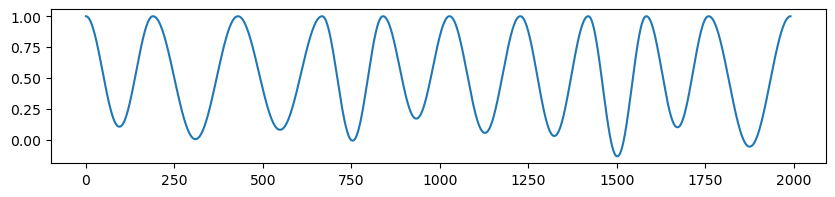

In [49]:
# now make the period and amplitude random variables
n_periods = 10
periods = torch.normal(1, .15, size=(n_periods,))
amplitudes = torch.normal(1, .15, size=(n_periods,))

def make_random_beta_oscillations(betas, n_periods=1, periods=[100], amplitudes=[1]):
    beta_multiple_periods = []
    periods = (periods*100).to(torch.int64)
    for i in range(int(n_periods)):
        period = periods[i]
        amplitude = amplitudes[i]
        b_l_different_amp_min = convert_beta_t_to_beta_l(1-amplitude, betas)
        beta_ls = make_beta_schedule('sine', period, end=b_l_different_amp_min)
        beta_ts = convert_beta_l_to_beta_t(torch.cat([beta_ls, reversed(beta_ls)]), betas)
        beta_multiple_periods.append(beta_ts)
    beta_multiple_periods = torch.cat(beta_multiple_periods)
    return beta_multiple_periods

betas_multiple_periods = make_random_beta_oscillations(betas, n_periods=10, periods=periods, amplitudes=amplitudes)
print(betas_multiple_periods.shape)

fig, ax = plt.subplots(1, 1, figsize=(10, 2))
ax.plot(betas_multiple_periods)

In [58]:
from prior_utils import p_rev_loop, p_sample_loop

global device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

def get_coefficients(num_steps, device, schedule='sigmoid', start=1e-5, end=2e-2):
    '''calculate the forward process for the given noise schedule'''
    from utils import make_beta_schedule
    betas = make_beta_schedule(schedule=schedule, n_timesteps=num_steps, start=start, end=end, device=device)
    alphas = 1 - betas
    alphas_prod = torch.cumprod(alphas, 0)
    one_minus_alphas_prod_sqrt = torch.sqrt(1 - alphas_prod)
    return betas, alphas, one_minus_alphas_prod_sqrt

@torch.no_grad()
def p_sample(model, x, t, n_steps, alphas, betas, one_minus_alphas_prod_sqrt, device):
    """
    returns one step of the neural forward process. takes a noisy data sample x_{t-1} and returns a more noisy x_t.
    """
    from utils import extract
    t = torch.tensor([t], device=device)
    T = t.repeat(x.shape[0], 1)
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_prod_sqrt, t, x))
    # Model output
    eps_theta = model(x, T)
    # Final values
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    # Generate z
    z = torch.randn_like(x, device=device)
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt()
    sample = mean + sigma_t * z
    return sample

# ------- alternating between the neural forward and reverse processes ------- #
def perform_one_cycle(init_x, model, num_steps, coefficients, schedule='sine'):
    '''
    undergoes one cycle of the oscillation.
    diffuses the datapoints using the neural forward process, and then anti-diffuses using the neural reverse process.
    '''
    betas, alphas, one_minus_alphas_prod_sqrt = coefficients
    
    if type(init_x) == np.ndarray:
        init_x = torch.tensor(init_x, dtype=torch.float)
    else: 
        init_x = init_x
    
    # neural forward process
    cur_x = init_x
    for i in range(num_steps):
        cur_x = p_sample(model, cur_x, i, num_steps, alphas, betas, one_minus_alphas_prod_sqrt, device)
    
    # neural reverse process
    for i in reversed(range(num_steps)):
        cur_x = p_sample(model, cur_x, i, num_steps, alphas,betas,one_minus_alphas_prod_sqrt, device)
    return cur_x


def neural_sampling_custom_betas(model, init_x, num_cycles, betas, period=1, amplitude=1, disable_tqdm=False, schedule='sine'):
    # customize beta schedule
    from utils import convert_beta_t_to_beta_l
    import numbers
    
    num_cycles = int(num_cycles)
    
    if isinstance(period, numbers.Number) and isinstance(amplitude, numbers.Number):
        # both period and amplitude are scalars
        num_steps = int(100*period)
        b_l_different_amp_min = convert_beta_t_to_beta_l(1-amplitude, betas)
        coefficients = get_coefficients(num_steps, device, schedule, end=b_l_different_amp_min)
    elif isinstance(period, (list, torch.Tensor, np.ndarray)) and isinstance(amplitude, (list, torch.Tensor, np.ndarray)):
        # both period and amplitude are lists
        num_steps_per_cycle = (100*period).to(torch.int64)
        b_l_different_amp_min = convert_beta_t_to_beta_l(1-amplitude, betas)
        coeff_per_cycle = []
        for i in range(num_cycles):
            coeff = get_coefficients(num_steps_per_cycle[i], device, schedule, end=b_l_different_amp_min[i])
            coeff_per_cycle.append(coeff)
    else:
        raise ValueError('period and amplitude must both be scalars or lists/array/tensors')
    
    if type(init_x) == np.ndarray:
        init_x = torch.tensor(init_x, dtype=torch.float)
    else: 
        init_x = init_x
    
    # burn the first sample
    coefficients = get_coefficients(100, device, schedule)
    x = perform_one_cycle(init_x, model, 100, coefficients, schedule)
    
    seq_x = []    
    for i in tqdm(range(num_cycles), disable=disable_tqdm):
        if not isinstance(period, numbers.Number) and not isinstance(amplitude, numbers.Number):
            coefficients = coeff_per_cycle[i]
            num_steps = num_steps_per_cycle[i]
        x = perform_one_cycle(x, model, num_steps, coefficients, schedule)
        seq_x.append(x)
    seq_x = torch.stack(seq_x).detach().cpu().numpy().reshape(num_cycles, -1)
    return seq_x

def repeat_scalar(scalar, repeats):
    return torch.tensor(scalar).tile(int(repeats))
    

Using device: cuda


In [59]:
# model
from utils import select_model, make_beta_schedule
model, num_steps, embedding_dims = select_model('unconditional-dendritic-4-layers', 1)
model.to(device)

# dataset
from dataset_utils import generate_2d_swiss_roll
dataset = generate_2d_swiss_roll(int(1e3), True, True)[1]

# sample a random datapoint from the dataset
init_x = dataset[np.random.randint(0, len(dataset))].reshape(-1, 2).to(device)
original_betas = make_beta_schedule('sine', n_timesteps=n_timesteps)

model loaded!


# original beta

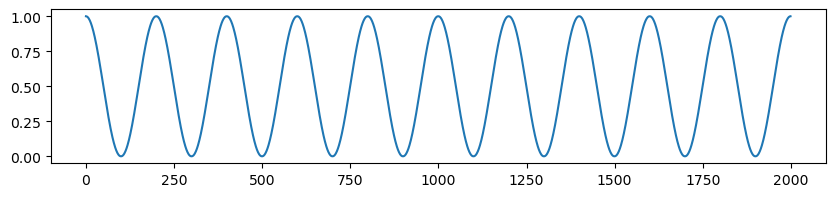

In [60]:
# draw samples using the normal beta oscillations
num_samples = 10
period = 1
amplitude = 1

periods = repeat_scalar(period, num_samples)
amplitudes = repeat_scalar(amplitude, num_samples)
betas_multiple_periods = make_random_beta_oscillations(betas, num_samples, periods, amplitudes)

fig, ax = plt.subplots(1, 1, figsize=(10, 2))
ax.plot(betas_multiple_periods)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot: >

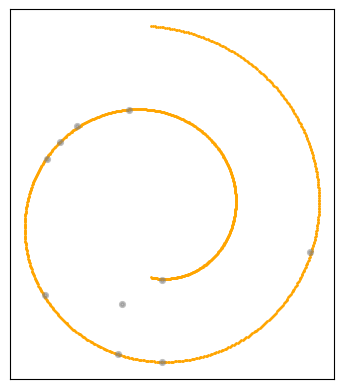

In [61]:
num_samples = 1e3
period = 1
amplitude = 1
periods = repeat_scalar(period, num_samples)
amplitudes = repeat_scalar(amplitude, num_samples)
x_seq_original = neural_sampling_custom_betas(model, init_x, num_samples, original_betas, period, amplitude)

fig, ax = plt.subplots(1, 1)
ax.scatter(dataset[:, 0], dataset[:, 1], s=1, c='orange')
ax.scatter(*x_seq_original.T, s=10, alpha=0.5, lw=2, c='grey')
ax.set(aspect='equal')
remove_all_ticks_and_labels(ax)

# only period is a random variable

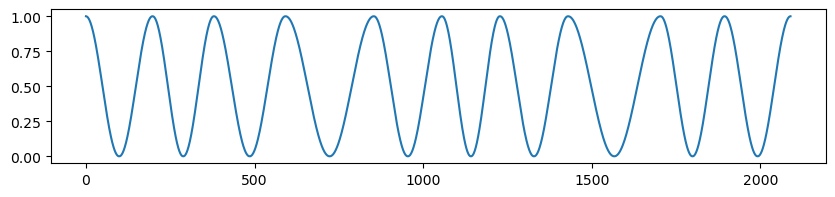

In [62]:
num_samples = 10
periods = torch.normal(1, .15, size=(int(num_samples),))
amplitude = 1
amplitudes = repeat_scalar(amplitude, num_samples)
betas_multiple_periods = make_random_beta_oscillations(betas, num_samples, periods, amplitudes)

fig, ax = plt.subplots(1, 1, figsize=(10, 2))
ax.plot(betas_multiple_periods)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot: >

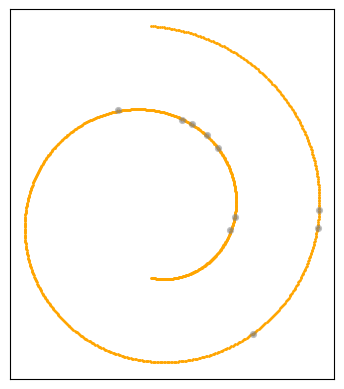

In [63]:
num_samples = 1e3
periods = torch.normal(1, .15, size=(int(num_samples),))
amplitude = 1
amplitudes = repeat_scalar(amplitude, num_samples)
x_seq_random_period = neural_sampling_custom_betas(model, init_x, num_samples, original_betas, periods, amplitudes)

fig, ax = plt.subplots(1, 1)
ax.scatter(dataset[:, 0], dataset[:, 1], s=1, c='orange')
ax.scatter(*x_seq_random_period.T, s=10, alpha=0.5, lw=2, c='grey')
ax.set(aspect='equal')
remove_all_ticks_and_labels(ax)

# only amplitude is a random variable

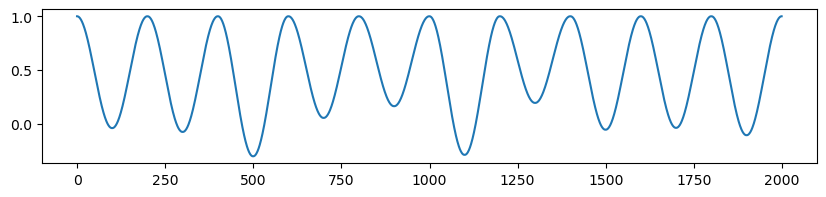

In [64]:
num_samples = 10
period = 1
periods = repeat_scalar(period, num_samples)
amplitudes = torch.normal(1, .15, size=(int(num_samples),))
betas_multiple_periods = make_random_beta_oscillations(betas, num_samples, periods, amplitudes)

fig, ax = plt.subplots(1, 1, figsize=(10, 2))
ax.plot(betas_multiple_periods)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot: >

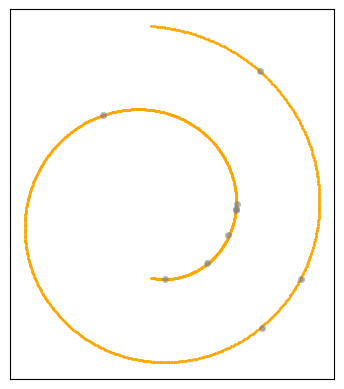

In [66]:
num_samples = 10
period = 1
periods = repeat_scalar(period, num_samples)
amplitudes = torch.normal(1, .15, size=(int(num_samples),))
x_seq_random_amplitude = neural_sampling_custom_betas(model, init_x, num_samples, original_betas, periods, amplitudes)

fig, ax = plt.subplots(1, 1)
ax.scatter(dataset[:, 0], dataset[:, 1], s=1, c='orange')
ax.scatter(*x_seq_random_amplitude.T, s=10, alpha=0.5, lw=2, c='grey')
ax.set(aspect='equal')
remove_all_ticks_and_labels(ax)

# both period and amplitude are random variables

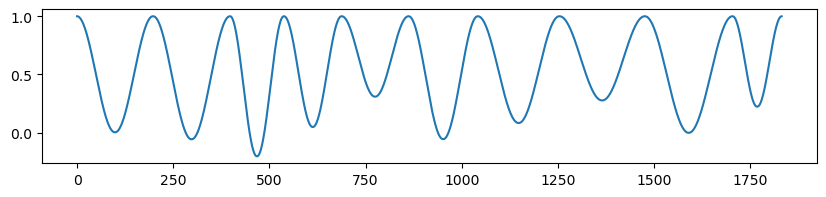

In [35]:
num_samples = 10
periods = torch.normal(1, .15, size=(int(num_samples),))
amplitudes = torch.normal(1, .15, size=(int(num_samples),))

betas_multiple_periods = make_random_beta_oscillations(betas, num_samples, periods, amplitudes)

fig, ax = plt.subplots(1, 1, figsize=(10, 2))
ax.plot(betas_multiple_periods)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot: >

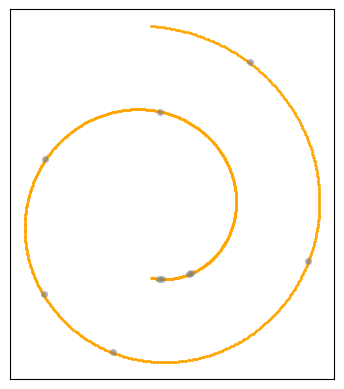

In [44]:
num_samples = 1e4
periods = torch.normal(1, .15, size=(num_samples,))
amplitudes = torch.normal(1, .15, size=(num_samples,))
x_seq_random_both = neural_sampling_custom_betas(model, init_x, num_samples, original_betas, periods, amplitudes)

fig, ax = plt.subplots(1, 1)
ax.scatter(dataset[:, 0], dataset[:, 1], s=1, c='orange')
ax.scatter(*x_seq_random_both.T, s=10, alpha=0.5, lw=2, c='grey')
ax.set(aspect='equal')
remove_all_ticks_and_labels(ax)

# kl divergence between ground truth and generated samples